<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Single Star Lightcurve with the Butler</b> <br>
Last verified to run on 2021-07-22 with LSST Science Pipelines release w_2021_25 <br>
Contact authors: Melissa Graham, Jeff Carlin <br>
Target audience: All DP0 delegates. <br>
Container Size: medium <br>
Questions welcome at <a href="https://community.lsst.org/c/support/dp0">community.lsst.org/c/support/dp0</a>. <br>
Find DP0 documentation and resources at <a href="https://dp0-1.lsst.io">dp0-1.lsst.io</a>. <br>

**Credit:** This tutorial notebook was created by Jeff Carlin, Leanne Guy, and Melissa Graham, and draws on material in the fourth notebook "04 Intro to Butler".

### Caveats

The DP0.1 data set is not well suited to large-scale time domain analyses, and one goal of this notebook is to clearly illustrate the limitations.

The DP0.1 data set does not contain any data products from difference image analysis.

A catalog of sources detected in processed visit images (PVIs) is available via the Butler (read more in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd)).
However, this source catalog does not include *associations* of PVI sources by sky coordinate, nor associations between PVI sources and objects detected in the deep coadded images.

It is recommended that DP0 delegates work through the Butler notebooks "01 Intro to DP0 Notebooks" and "04 Intro to Butler" before using this notebook.

### Learning Objectives

First, use the TAP Service to find a time-domain target to make a light curve for.

Then, use the Butler to retrieve all detected sources from all processed visit images (PVIs or `calexps`) at a given sky coordinate, and plot magnitude as a function of time.

In [1]:
# %load_ext pycodestyle_magic
# %flake8_on

### Set Up

Import the packages we will need for this notebook.

In [42]:
### Rubin-specific packages

import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.sphgeom as sphgeom
import lsst.daf.base as dafBase

# from rubin_jupyter_utils.lab.notebook import get_tap_service #, retrieve_query    
# service = get_tap_service()

### General python / astronomy packages

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits

import time

Create an instance of the Butler.

In [7]:
repo = 's3://butler-us-central1-dp01'
butler = dafButler.Butler(repo)
registry = butler.registry
collection = "2.2i/runs/DP0.1"

### 1. Use the TAP Service to choose a variable star.

Retrieve the RA and Dec of elements in the `truth_match` table that are within a 1 degree radius circle near the center of the DC2 region, and have `is_variable = 1` (is variable), `truth_type = 2` (is a star), and `mag_r > 20` (r-band AB magnitude is brighter than 20).
Find more information about the `truth_match` table in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd).

In [8]:
# results = service.search("SELECT ra, dec "\
#                          "FROM dp01_dc2_catalogs.truth_match "\
#                          "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "\
#                          "AND is_variable = 1 AND truth_type = 2 AND mag_r > 20 ", maxrec=10000)

In [9]:
## Alternative: use TAP service to choose a Type Ia supernova: truth_type = 3
# results = service.search("SELECT ra, dec, host_galaxy "\
#                          "FROM dp01_dc2_catalogs.truth_match "\
#                          "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 62.0, -37.0, 1.0)) = 1 "\
#                          "AND truth_type = 3 ", maxrec=10000)

Convert the results to a pandas data frame and show it.

In [20]:
# data = results.to_table().to_pandas()
# data

Clean up, we don't need these anymore.

In [7]:
# del results,data
# del service

### 2. Execute spatial search of the `src` catalogs with the Butler.

For now, we will select a star that is known to be a simulated RR Lyrae variable. The star of interest is located at a position (RA, Dec) = (60.2837946, -35.4042439) degrees. 

Use [astropy.SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) to define a coordinate object for this variable star.

In [22]:
# targ_coord = SkyCoord(ra=62.1803311*u.deg, dec=-37.0137459*u.deg)
targ_coord = SkyCoord(ra=60.2837946*u.deg, dec=-35.4042439*u.deg)

Use these coordinates to define the HTM ID spatial search region to pass to the Butler's `queryDatasets` function.

Find more details about sky pixelization with HTM and Butler spatial queries in Section 2.5 of notebook "04 Intro to Butler".

In [23]:
pixelization = sphgeom.HtmPixelization(15)
htm_id = pixelization.index(sphgeom.UnitVector3d(sphgeom.LonLat.fromDegrees(targ_coord.ra.value, targ_coord.dec.value)))

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=9418649859 at level=15 is a ~8.4" triangle.


<br>

Now we will query the `src` datasets (i.e., measurements from each processed visit image) for this HTM pixel via the Butler. Notice that the ID for the HTM triangle of interest was extracted using the RA, Dec coordinates of the star of interest. When we extract dataset references, we can limit it to return only catalogs overlapping that HTM "pixel."

To keep things simple, we will just query for r-band data.

Find more details about the `src` catalog in the [DP0.1 DPDD](https://dp0-1.lsst.io/data-products-dp0-1/index.html#dp0-1-data-products-definition-document-dpdd).

In [24]:
datasetRefs = registry.queryDatasets("src", htm20=htm_id, collections=collection, where="band in ('r')")

In [25]:
datasetRefs

Extract the datasetRefs into a python list called `refs` to speed up access to the dataIds in Section 3. This may take a little while (~30 seconds).

In [26]:
ii = 0
refs = []
for i, ref in enumerate(datasetRefs):
    refs.append( ref )
    ii += 1
print(ii,' catalogs matching the requested position.')

108  catalogs matching that position.


<br>

Let's take a look at a `dataId` from the list we have compiled. It should specify the `visit` and `detector` containing the star, and the `band` (r) that we specified in the query.

In [28]:
refs[0].dataId.full

{band: 'r', instrument: 'LSSTCam-imSim', detector: 180, physical_filter: 'r_sim_1.4', visit_system: 1, visit: 694278}

### 3. Loop over search results and store `src` data in python lists.

For each query result (i.e., each element of `refs`), use the `dataId` to retrieve all sources for that query result.

Calculate the separation of each source from the target. If the nearest source is within 1.5" of the target, it probably *is* the target.

We will store the RA, Dec, separation (between the supplied position and the measured position in each visit image), r-band magnitude, visit and detector IDs, and date of observation (in "Modified Julian Date," or MJD) for that source into python lists.

This requires extracting the `calexp` so that we can access its `photoCalib` and `visitInfo` (which contains the date of observation) for each visit  (and, of course, extracting the `src` catalog).

(NOTE: this takes a _long_ time (many minutes) to run...)

In [45]:
### Instantiate empty lists
ra_arr = []
dec_arr = []
sep_arr = []
mag_arr = []
visit_arr = []
detector_arr = []
mjd_arr = []

for i, d in enumerate(refs):
    
    if i < 1000:

        # t1 = time.time()

        # Use the butler to get all sources for this datasetRef's dataId
        did = d.dataId.full
        src = butler.get('src', dataId=did, collections=collection)
        # t2 = time.time()
        print('i, len(src) = ', i, len(src))
        # print('t2-t1 = ', t2-t1)

        # Get the separation of all sources from the target
        src_coords = SkyCoord(ra=src['coord_ra']*u.rad, dec=src['coord_dec']*u.rad)
        sep = src_coords.separation(targ_coord)
        # t3 = time.time()
        # print('t3-t2 = ', t3-t2)

        # If the nearest source is within 1.5", add it to our list
        if np.min(sep.arcsecond) < 1.5:
            sx = np.argmin(sep.arcsecond)
            ra_arr.append(src['coord_ra'][sx])
            dec_arr.append(src['coord_dec'][sx])

            # Extract the PVI:
            calexp = butler.get('calexp', dataId=did, collections=collection)

            # Extract the photocalib and apply it to calculate a magnitude:
            #calib = butler.get('calexp.photoCalib', dataId=did, collections=collection)
            calib = calexp.getPhotoCalib()
            mag_arr.append(calib.instFluxToMagnitude(src['base_PsfFlux_instFlux'][sx]))

            # Calculate the AB magnitude from the calibrated flux in nJy
            # "calibrated flux" = base_PsfFlux_instFlux * base_localPhotoCalib
            # rmag_arr.append( -2.5 * np.log10( src['base_PsfFlux_instFlux'][sx] * src['base_localPhotoCalib'][sx] ) + 31.4 )
            # t4 = time.time()
            # print('t4-t3 = ',t4-t3)

            # Retrieve the mjd date for this dataId from the image header for this dataid
            date_obs = calexp.getInfo().getVisitInfo().getDate()
            mjd_arr.append(date_obs.get(dafBase.DateTime.MJD))
            # visit_info = butler.get('calexp.visitInfo', dataId=did, collections=collection)
            # mjd_arr.append(visit_info.getDate().get(lsst.daf.base.DateTime.MJD))
            # t5 = time.time()
            # print('t5-t4 = ',t5-t4)

            sep_arr.append(sep[sx].arcsecond)
            visit_arr.append(did['visit'])
            detector_arr.append(did['detector'])
            
            del sx, date_obs

        del did, src, src_coords, sep

i, len(src) =  0 1919
i, len(src) =  1 3086
i, len(src) =  2 2753
i, len(src) =  3 2644
i, len(src) =  4 2652
i, len(src) =  5 1643
i, len(src) =  6 2270
i, len(src) =  7 2791
i, len(src) =  8 1771
i, len(src) =  9 2862
i, len(src) =  10 2576
i, len(src) =  11 3063
i, len(src) =  12 1817
i, len(src) =  13 1825
i, len(src) =  14 2837
i, len(src) =  15 2711
i, len(src) =  16 1801
i, len(src) =  17 1998
i, len(src) =  18 3186
i, len(src) =  19 3602
i, len(src) =  20 3260
i, len(src) =  21 2913
i, len(src) =  22 1834
i, len(src) =  23 3214
i, len(src) =  24 3371
i, len(src) =  25 2225
i, len(src) =  26 2413
i, len(src) =  27 2325
i, len(src) =  28 2227
i, len(src) =  29 3199
i, len(src) =  30 2747
i, len(src) =  31 1800
i, len(src) =  32 1680
i, len(src) =  33 1898
i, len(src) =  34 1914
i, len(src) =  35 3398
i, len(src) =  36 2417
i, len(src) =  37 2451
i, len(src) =  38 1907
i, len(src) =  39 3528
i, len(src) =  40 2411
i, len(src) =  41 2751
i, len(src) =  42 2802
i, len(src) =  43 212

In [47]:
# Make an Astropy Table of the data:
tab_timeseries = Table([mjd_arr, ra_arr, dec_arr, sep_arr, mag_arr, visit_arr, detector_arr],
                       names=['mjd', 'ra', 'dec', 'separation', 'mag', 'visit', 'detector'])

# Save the timeseries data to a FITS file for later use:
# tab_timeseries.write('timeseries_rband.fits', overwrite=True)

In [48]:
# Uncomment the following to read the saved timeseries data:
tab_timeseries = fits.getdata('timeseries_rband.fits')

In [49]:
tab_timeseries.columns

ColDefs(
    name = 'mjd'; format = 'D'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'separation'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'visit'; format = 'K'
    name = 'detector'; format = 'K'
)

### 4. Plot a time series (magnitude vs. time) of the star's measurements:

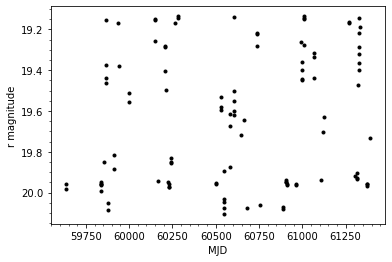

In [50]:
plt.plot(tab_timeseries['mjd'], tab_timeseries['mag'], 'k.')
plt.xlabel('MJD')
plt.ylabel('r magnitude')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.show()

Hooray! The star is clearly a variable, with a peak-to-peak variation of almost a full magnitude.

Plot the RA vs. Dec to show the dispersion in coordinate and get a sense of how well a 1.5 arcsecond limit for source association has worked in this case.
Seeing two clumps of points might indicate there is another nearby point-source.

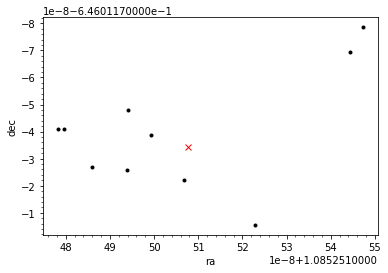

In [13]:
plt.plot(ra_arr, dec_arr, 'k.')
plt.plot(targ_coord.ra.rad,targ_coord.dec.rad, 'x', color='red')
plt.xlabel('ra')
plt.ylabel('dec')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.show()

In [ ]:
plt.plot(mjd_arr, rmag_arr, 'k.')
plt.xlabel('ra')
plt.ylabel('dec')
plt.gca().invert_yaxis()
plt.minorticks_on()
plt.show()